Steps for clustering algorithm (what has been done manually and now needs to be automated)

1. Seasonality : 4 hour window periods
2. Standard deviation for 4 hour periods
3. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
4. Rate of glucose appearance and disappearance

    a. Glucose excursion (nadir to peak / peak to nadir) - +ve and -ve trends

    b. iAUC (nadir to peak / peak to nadir) - +ve and -ve trends
    
5. Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 

6. Incude the Carbs consumed in the 4 hour period

7. Collate the results of the above points into a data set with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

8. Run Clustering Algorithm

9. Goodness of fit assessment :

- Want the algorithm to be adaptive.

    Have the left overs recycled through the 'rules' missing the glucose excursion but maintaining the iAUC and total change in BG. 
    
    Then further iterations miss out the iAUC and review total change in BG etc

First things first:
Import/load necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, date
import calendar
import time

from datetime import timedelta
from statistics import mode

%matplotlib inline

Load and preprocess necessary data sets

In [2]:
# Import data
unfiltered = pd.read_csv('./CSV Files/544_data.csv')
unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], format="%d/%m/%Y %H:%M")
unfiltered.drop('glucose_level_mmol/L', axis=1)

,glucose_level_ts,glucose_level_mg/dL,carbs_g,meal_ts,meal_type,bolus_dose,bolus_start_ts,bolus_end_ts,bolus_type
0,2020-05-11 00:02:00,129,135.0,11/05/2020 11:25,Lunch,7.1,11/05/2020 08:24,11/05/2020 08:24,normal
1,2020-05-11 00:07:00,128,100.0,11/05/2020 17:16,Dinner,16.8,11/05/2020 11:24,11/05/2020 11:24,normal
2,2020-05-11 00:12:00,129,42.0,11/05/2020 21:26,Snack,14.2,11/05/2020 17:19,11/05/2020 17:19,normal
3,2020-05-11 00:17:00,131,37.0,12/05/2020 08:02,Breakfast,7.5,11/05/2020 21:23,11/05/2020 21:23,normal
4,2020-05-11 00:22:00,133,78.0,12/05/2020 12:07,Lunch,6.9,12/05/2020 08:00,12/05/2020 08:00,normal
...,...,...,...,...,...,...,...,...,...
13334,2020-07-04 20:57:00,296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13335,2020-07-04 21:02:00,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13336,2020-07-04 21:07:00,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13337,2020-07-04 21:12:00,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Here we filter the unfiltered for glucose level and glucose_ts to use in isolating the glucose events.
# We will pick up the unfiltered datset again later when looking at CHO and Insulin levels.

features = ['glucose_level_ts', 'glucose_level_mg/dL']
data = unfiltered[features].copy()

# Convert timestamp to datetime format
data['glucose_level_ts'] = pd.to_datetime(data['glucose_level_ts'])

# Remove the first row
data = data.iloc[1:].reset_index(drop=True)

# Map day of week names to day of week numbers
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 7: 'Sunday'}
data['day_of_week'] = data['glucose_level_ts'].dt.dayofweek.map(day_names)


# Make sure time series is (roughly) uniform
time_step = mode(data['glucose_level_ts'].diff())
time_step_minutes = time_step/timedelta(minutes=1)
assert(time_step_minutes == 5)

date_index = pd.date_range(start=min(data['glucose_level_ts']), end=max(data['glucose_level_ts']),freq=time_step)
data = data.reset_index() # store original index, just in case
data = data.set_index(data['glucose_level_ts'])
data = data.reindex(date_index, method='nearest', tolerance = time_step)
data = data.reset_index(drop=True)

# Calculate rate of change
data['BG Rate of Change'] = data['glucose_level_mg/dL'].diff()/time_step_minutes

data

# plt.plot(data['glucose_level_mg/dL'])   

,index,glucose_level_ts,glucose_level_mg/dL,day_of_week,BG Rate of Change
0,0.0,2020-05-11 00:07:00,128.0,Monday,NaN
1,1.0,2020-05-11 00:12:00,129.0,Monday,0.2
2,2.0,2020-05-11 00:17:00,131.0,Monday,0.4
3,3.0,2020-05-11 00:22:00,133.0,Monday,0.4
4,4.0,2020-05-11 00:27:00,132.0,Monday,-0.2
...,...,...,...,...,...
15802,13333.0,2020-07-04 20:57:00,296.0,Saturday,0.0
15803,13334.0,2020-07-04 21:02:00,292.0,Saturday,-0.8
15804,13335.0,2020-07-04 21:07:00,284.0,Saturday,-1.6
15805,13336.0,2020-07-04 21:12:00,273.0,Saturday,-2.2


Step 2:

Isolate the peak and nadir (low) points in the set windows

Found 214 peaks
Found 158 throughs


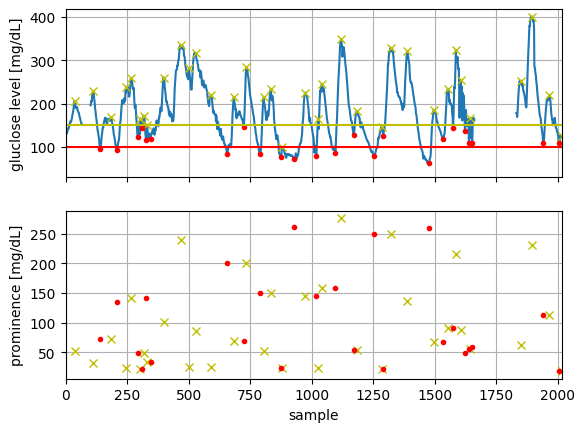

In [4]:
# Convert data to numpy arrays
glucose_level_ts = data['glucose_level_ts'] 
glucose_level = np.array(data['glucose_level_mg/dL'], dtype=float)
glucose_change = np.array(data['BG Rate of Change'], dtype=float)

# Set threshold values for glycemic events
glucose_threshold_low = 100  # mg/dL (5.5 mmol/L)
glucose_threshold_high = 150 # mg/dL (8.3 mmol/L)
rate_of_change_threshold = 0 # mg/dL/min (0.3 mmol/L) see note below (*)

# Set the `rate_of_change_threshold`.
# the difference is that, this way, the peak must be `prominence` units above "neighboring" points, 
# but this doesn't have to happen exactly within three timesteps.
prominence = 3.6*5 # mg/dL

# this parameter helps avoid detecting several small peaks within a larger structure
min_samples_between_peaks = timedelta(hours=1)/time_step

from scipy.signal import find_peaks, peak_prominences

idx_peaks,_ = find_peaks(glucose_level,
                         height=glucose_threshold_low,
                         threshold=rate_of_change_threshold*time_step_minutes,
                         distance=min_samples_between_peaks,
                         prominence=prominence,
                         width=None, wlen=None, rel_height=0.5, plateau_size=None) 
#rel_height = detect peaks and nadirs that are at east 50% as high as the highest peak 

idx_nadirs,_ = find_peaks(-glucose_level,
                          height=-glucose_threshold_high,
                          threshold=rate_of_change_threshold*time_step_minutes,
                          distance=min_samples_between_peaks,
                          prominence=prominence,
                          width=None, wlen=None, rel_height=0.5, plateau_size=None)

print("Found",len(idx_peaks),"peaks")
print("Found",len(idx_nadirs),"throughs")

_, ax = plt.subplots(2, sharex=True)
for j in [0,1]: ax[j].grid()

window_days = 7
offset = 0 # days from start (change this to look at other weeks)

ax[0].plot(glucose_level)
ax[0].plot(idx_peaks, glucose_level[idx_peaks], "yx")
ax[0].plot(idx_nadirs, glucose_level[idx_nadirs], "r.")
ax[0].set_xlim(offset*(24*60/5), (offset+window_days)*24*60/5)
ax[0].axhline(y = glucose_threshold_low, color = 'r')
ax[0].axhline(y = glucose_threshold_high, color = 'y')
ax[0].set_ylabel('gluclose level [mg/dL]')

prominences = peak_prominences(glucose_level,idx_peaks)[0]
ax[1].plot(idx_peaks, prominences, "yx")

prominences = peak_prominences(-glucose_level,idx_nadirs)[0]
ax[1].plot(idx_nadirs, prominences, "r.")

ax[1].set_ylabel('prominence [mg/dL]')
ax[1].set_xlabel('sample')
    
plt.show()

In [12]:
# Set time threshold values for glycemic events
max_nadir_to_peak_time = timedelta(hours=1)
max_peak_to_2nd_nadir_time = timedelta(hours=4)

# Initialize events list
events = []

VERBOSE = False #False # set to True for parameter tuning/debugging

# Ignore peaks that appear before any nadirs, or that have no (secondary) nadir afterwards
ignored_peaks = (idx_peaks < idx_nadirs[0]) | (idx_peaks > idx_nadirs[-1])  

counter =0
# Loop through all peaks
for i, idx in enumerate(idx_peaks):
    
    if ignored_peaks[i]: 
        if VERBOSE: print(f"peak #{i} ({idx}) ignored")             # Checks to see if the isolated peak needs to be ignored from above
        continue    
    
    # Find the last nadir event that occurred before the peak event
    j = idx_nadirs[ np.flatnonzero(idx_nadirs < idx)[-1] ]  
   # print(j)        # This line finds the index of the last nadir event that occurred before the current peak. 
                                                                    # It does this by first using np.flatnonzero to find the indices of all nadirs that occurred before the current peak index (idx). 
                                                                    # It then selects the last index in this array using [-1]. The resulting index is stored in j.

    # check that event occurred within the time threshold
    if (idx - j)*time_step < max_nadir_to_peak_time:                # This block checks if the time between the current peak and the last nadir (idx - j) is less than a threshold value (max_nadir_to_peak_time). 
                                                                    # If it is, the glucose level and timestamp of the last nadir are stored in the initial_nadir variable.
        initial_nadir = (glucose_level[j], glucose_level_ts[j])     # If it's not, the block prints a message indicating that no nadir was found for the current peak and the loop skips to the next iteration.
        
    else:
        if VERBOSE: print(f"No nadir found for peak #{i} ({idx})")  
        continue # nadir too far behind peak
            
            
    # Find the first nadir event that occurred after the peak event 
    k = idx_nadirs[ np.flatnonzero(idx_nadirs > idx_peaks[i])[0] ]  # This line finds the index of the first nadir event that occurred after the current peak.
                                                                    # It does this by first using np.flatnonzero to find the indices of all nadirs that occurred after the current peak index (idx_peaks[i])
                                                                    # It then selects the first index in this array using [0]. The resulting index is stored in k.    
    
    # check that event occurred within the time threshold
    if (k - idx)*time_step < max_peak_to_2nd_nadir_time:            # This block checks if the time between the next nadir (k) and the current peak (idx) is less than a threshold value (max_peak_to_2nd_nadir_time).
                                                                    #  If it is, the glucose level and timestamp of the next nadir are stored in the secondary_nadir variable.
        secondary_nadir = (glucose_level[k], glucose_level_ts[k])   # If it's not, the block prints a message indicating that no secondary nadir was found for the current peak and the loop skips to the next iteration.
        
    else:
        if VERBOSE: print(f"No secondary nadir found for peak #{i} ({idx})")
        continue # nadir too far ahead of peak
    
    
    # What to do if there is more than one peak within j and k?
    between_jk = np.flatnonzero( (idx_peaks > j) & (idx_peaks < k) ) # This line finds the indices of all peaks that occurred between the last nadir (j) and the next nadir (k).
                                                                     # It does this by first creating a boolean array that is True for all peaks that occur between j and k. It then uses `np.flatnonzero
    #print(len(between_jk))
    if len(between_jk) > 1:
    # Currently: ignore all but the highest of them
        counter = counter + 1 
    
        idx_peaks_jk = idx_peaks[between_jk]                         # The actual indices of peaks between j and k
        l = idx_peaks_jk[ np.argmax(glucose_level[ idx_peaks_jk ]) ] # Assigns the index of the peak with the highest glucose level value between the last nadir event and the next nadir event

        # Make sure peak l is not accounted twice
        ignored_peaks[ between_jk ] = True                           # Marks all peaks between the last nadir event and the next nadir event, except the highest peak, as ignored so that they won't be considered again.

        event_peak = (glucose_level[l], glucose_level_ts[l])         # Assigns the glucose level value and timestamp of the highest peak as the event_peak.
        
        if VERBOSE: print(f"Choosing ({l}), out of",len(between_jk),"peaks between",j,"and",k)  # Prints a message indicating the index of the chosen peak and the total number of peaks between the last nadir event and the next nadir event.
    else:
        event_peak = (glucose_level[idx], glucose_level_ts[idx])     # Assigns the glucose level value and timestamp of the only peak as the event_peak.
        if VERBOSE: print(f"Single peak #{i} ({idx}) between {j} and {k}")  # Prints a message indicating that there is only one peak between the last nadir event and the next nadir event, 
                                                                            # along with its index and the indices of the last nadir event and the next nadir event.

    # Calculate the positive and negative glucose excursions
    #positive_excursion = event_peak[0] - initial_nadir[0]
    #negative_excursion = event_peak[0] - secondary_nadir[0]

    # Add the event to the events list
    events.append({
        'initial_nadir_idx': j,
        'initial_nadir_glucose': initial_nadir[0],
        'initial_nadir_time': initial_nadir[1],
        'peak_glucose': event_peak[0],
        'peak_time': event_peak[1],
        'secondary_nadir_glucose': secondary_nadir[0],
        'secondary_nadir_time': secondary_nadir[1]
    })

print("number of inbetweens " + str(counter))
# Create a pandas dataframe from the events list
df_events = pd.DataFrame.from_dict(events)
df_events

number of inbetweens 1


,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time
0,293,124.0,2020-05-12 00:34:00,165.0,2020-05-12 01:24:00,143.0,2020-05-12 02:09:00
1,312,143.0,2020-05-12 02:09:00,172.0,2020-05-12 02:34:00,117.0,2020-05-12 03:24:00
2,327,117.0,2020-05-12 03:24:00,151.0,2020-05-12 03:39:00,118.0,2020-05-12 04:54:00
3,1575,143.0,2020-05-16 11:24:00,324.0,2020-05-16 12:19:00,137.0,2020-05-16 15:24:00
4,1639,110.0,2020-05-16 16:44:00,166.0,2020-05-16 17:04:00,108.0,2020-05-16 17:49:00
5,2072,120.0,2020-05-18 04:45:00,162.0,2020-05-18 05:10:00,123.0,2020-05-18 06:40:00
6,3592,97.0,2020-05-23 11:25:00,118.0,2020-05-23 12:05:00,90.0,2020-05-23 13:15:00
7,6777,98.0,2020-06-03 12:52:00,183.0,2020-06-03 13:47:00,134.0,2020-06-03 14:32:00
8,6797,134.0,2020-06-03 14:32:00,193.0,2020-06-03 15:17:00,72.0,2020-06-03 18:07:00
9,7065,109.0,2020-06-04 12:54:00,166.0,2020-06-04 13:44:00,138.0,2020-06-04 14:29:00


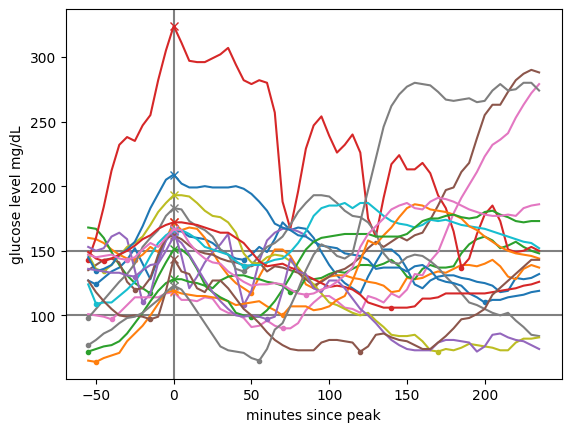

In [6]:
# Plot the series around detected events

if df_events.shape[0] == 0:
    print("No events detected :(")
else:
    
    ax = plt.gca()

    ax.axhline(y = glucose_threshold_high, color = 'gray')
    ax.axhline(y = glucose_threshold_low, color = 'gray')
    ax.axvline(x = 0, color = 'gray')
    ax.set_ylabel('glucose level mg/dL')
    ax.set_xlabel('minutes since peak')
    
    for j, t0 in enumerate(df_events['peak_time']):
        
        x = lambda t : (t - t0)/timedelta(minutes=1)
        
        idx = (glucose_level_ts > t0-max_nadir_to_peak_time) & (glucose_level_ts < t0+max_peak_to_2nd_nadir_time)        
        line = ax.plot(x(glucose_level_ts[idx]),glucose_level[idx],label=t0)
        ax.plot(x(df_events.loc[j,'initial_nadir_time']),df_events.loc[j,'initial_nadir_glucose'],'.',color=line[0].get_color())
        ax.plot(x(df_events.loc[j,'secondary_nadir_time']),df_events.loc[j,'secondary_nadir_glucose'],'.',color=line[0].get_color())
        ax.plot(x(df_events.loc[j,'peak_time']),df_events.loc[j,'peak_glucose'],'x',color=line[0].get_color())

    #ax.legend()    
    plt.show()

Step 3:

Calculate glucose appreance and disappearance rates

    a. Glucose excursion (mmol/L.min-1)
    
    b. iAUC

Step 4. 

Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 

In [100]:
# Calculate iAUC for positive and negative excursions
positive_iAUC = []
negative_iAUC = []

for i in range(len(df_events)):
    # Get glucose levels for the positive and negative excursions
    initial_nadir_glucose = df_events.loc[i, 'initial_nadir_glucose']
    peak_glucose = df_events.loc[i, 'peak_glucose']
    secondary_nadir_glucose = df_events.loc[i, 'secondary_nadir_glucose']
    
    positive_glucose = np.arange(initial_nadir_glucose, peak_glucose)
    negative_glucose = np.arange(peak_glucose, secondary_nadir_glucose)
    
    # Calculate iAUC for positive excursion
    positive_iAUC.append(np.trapz(positive_glucose))
    
    # Calculate iAUC for negative excursion
    negative_iAUC.append(np.trapz(negative_glucose))

# Add columns to DataFrame
df_events['positive_iAUC'] = positive_iAUC
df_events['negative_iAUC'] = negative_iAUC


df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,positive_iAUC,negative_iAUC
0,293,124.0,2020-05-12 00:34:00,165.0,2020-05-12 01:24:00,143.0,2020-05-12 02:09:00,5760.0,0.0
1,312,143.0,2020-05-12 02:09:00,172.0,2020-05-12 02:34:00,117.0,2020-05-12 03:24:00,4396.0,0.0
2,327,117.0,2020-05-12 03:24:00,151.0,2020-05-12 03:39:00,118.0,2020-05-12 04:54:00,4405.5,0.0
3,1575,143.0,2020-05-16 11:24:00,324.0,2020-05-16 12:19:00,137.0,2020-05-16 15:24:00,41940.0,0.0
4,1639,110.0,2020-05-16 16:44:00,166.0,2020-05-16 17:04:00,108.0,2020-05-16 17:49:00,7562.5,0.0


In [101]:
# Loop through each glucose event
for i in range(len(df_events)):
    # Get the glucose values for the current event
    idx = df_events.iloc[i]['initial_nadir_idx']
    
    # Calculate the positive and negative changes
    initial_nadir = df_events.iloc[i]['initial_nadir_glucose']
    peak = df_events.iloc[i]['peak_glucose']
    secondary_nadir = df_events.iloc[i]['secondary_nadir_glucose']
    positive_change = peak - initial_nadir
    negative_change = secondary_nadir - peak

    # Update the DataFrame with the calculated values
    df_events.at[i, 'total_change_positive'] = positive_change
    df_events.at[i, 'total_change_negative'] = negative_change

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,positive_iAUC,negative_iAUC,total_change_positive,total_change_negative
0,293,124.0,2020-05-12 00:34:00,165.0,2020-05-12 01:24:00,143.0,2020-05-12 02:09:00,5760.0,0.0,41.0,-22.0
1,312,143.0,2020-05-12 02:09:00,172.0,2020-05-12 02:34:00,117.0,2020-05-12 03:24:00,4396.0,0.0,29.0,-55.0
2,327,117.0,2020-05-12 03:24:00,151.0,2020-05-12 03:39:00,118.0,2020-05-12 04:54:00,4405.5,0.0,34.0,-33.0
3,1575,143.0,2020-05-16 11:24:00,324.0,2020-05-16 12:19:00,137.0,2020-05-16 15:24:00,41940.0,0.0,181.0,-187.0
4,1639,110.0,2020-05-16 16:44:00,166.0,2020-05-16 17:04:00,108.0,2020-05-16 17:49:00,7562.5,0.0,56.0,-58.0


Identify the carbohydrate intake and timestamps

In [103]:
#unfiltered.head()

Step 6. 

Collate the results of the above points into a data set with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

In [123]:
# Add columns for day name, day number, week of experiment, time of day 

unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'])
unfiltered['hour'] = unfiltered['glucose_level_ts'].dt.hour

def get_time_of_day(timestamp):
    hour = timestamp.hour
    if hour >=6 and hour < 12:
        return 'Morning'
    elif hour >=12 and hour < 17:
        return 'Afternoon'
    elif hour >=18 and hour < 22:
        return 'Evening'
    else:
        return 'Overnight'

df_events['time_of_day'] = df_events['initial_nadir_time'].apply(get_time_of_day)

In [124]:
df_events['day_names'] = unfiltered['glucose_level_ts'].dt.day_name()
#df_events['time_of_day'] = unfiltered['glucose_level_ts'].apply(get_time_of_day)
df_events['day_number'] = unfiltered['glucose_level_ts'].dt.dayofweek + 1
df_events['week_of_experiment'] = np.ceil(unfiltered['glucose_level_ts'].dt.dayofyear / 7)
df_events['carbs_g'] = unfiltered['carbs_g']
#df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,positive_iAUC,negative_iAUC,total_change_positive,total_change_negative,day_names,day_number,week_of_experiment,carbs_g,meal_type,time_of_day
0,293,124.0,2020-05-12 00:34:00,165.0,2020-05-12 01:24:00,143.0,2020-05-12 02:09:00,5760.0,0.0,41.0,-22.0,Monday,1,19.0,135.0,Lunch,Overnight
1,312,143.0,2020-05-12 02:09:00,172.0,2020-05-12 02:34:00,117.0,2020-05-12 03:24:00,4396.0,0.0,29.0,-55.0,Monday,1,19.0,100.0,Dinner,Overnight
2,327,117.0,2020-05-12 03:24:00,151.0,2020-05-12 03:39:00,118.0,2020-05-12 04:54:00,4405.5,0.0,34.0,-33.0,Monday,1,19.0,42.0,Snack,Overnight
3,1575,143.0,2020-05-16 11:24:00,324.0,2020-05-16 12:19:00,137.0,2020-05-16 15:24:00,41940.0,0.0,181.0,-187.0,Monday,1,19.0,37.0,Breakfast,Morning
4,1639,110.0,2020-05-16 16:44:00,166.0,2020-05-16 17:04:00,108.0,2020-05-16 17:49:00,7562.5,0.0,56.0,-58.0,Monday,1,19.0,78.0,Lunch,Afternoon


In [ ]:
# Save the DataFrame to a CSV file

file_path = '/Users/user/Desktop/Clustering Project/CSV Files/544_clustering_data.csv'

df_events.to_csv(path_or_buf=file_path, index=False)

IGNORE

In [ ]:
# Initialize events list
events = []

# Loop through the events in the 24 hour period
num_events_per_day = []
start_date = data['glucose_level_ts'].iloc[0].date()
end_date = data['glucose_level_ts'].iloc[-1].date()
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    events_in_period = 0
    for i in range(len(event_time_peak)):
        event_date = event_time_peak[i].date()
        if event_date == start_date:
            events_in_period += 1
    num_events_per_day.append(events_in_period)
    start_date += delta

# Loop through all events
for i in range(len(event_peak)):
    initial_nadir = None
    secondary_nadir = None

    # Find the initial nadir event that occurred before the peak event
    for j in range(len(event_nadir)):
        if event_time_nadir[j] < event_time_peak[i]:
            initial_nadir = (event_nadir[j], event_time_nadir[j])
        
    # Find the secondary nadir event that occurred after the peak event
    for k in range(len(event_secondary_nadir)):
        if event_time_secondary_nadir[k] > event_time_peak[i]:
            secondary_nadir = (event_secondary_nadir[k], event_time_secondary_nadir[k])
    
    # Calculate the positive and negative glucose excursions
    positive_excursion = event_peak[i] - initial_nadir[0] if initial_nadir is not None else None
    negative_excursion = event_peak[i] - secondary_nadir[0] if secondary_nadir is not None else None

    # Add the event to the events list
    initial_nadir_glucose = initial_nadir[0] if initial_nadir is not None else None
    initial_nadir_time = initial_nadir[1] if initial_nadir is not None else None
    peak_glucose = event_peak[i]
    peak_time = event_time_peak[i]
    secondary_nadir_glucose = secondary_nadir[0] if secondary_nadir is not None else None
    secondary_nadir_time = secondary_nadir[1] if secondary_nadir is not None else None
    events.append((initial_nadir_glucose, initial_nadir_time, peak_glucose, peak_time, secondary_nadir_glucose, secondary_nadir_time, positive_excursion, negative_excursion))

# Create a pandas dataframe from the events list
df_events = pd.DataFrame(events, columns=['initial_nadir_glucose', 'initial_nadir_time', 'peak_glucose', 'peak_time', 'secondary_nadir_glucose', 'secondary_nadir_time', 'positive_excursion', 'negative_excursion'])
df_events.head()

In [ ]:
# Convert data to numpy arrays
glucose_level_ts = np.array(data['glucose_level_ts'])
glucose_level = np.array(data['glucose_level_mg/dL'], dtype=float)
glucose_change = np.array(data['BG Rate of Change'], dtype=float)

# Set threshold values for glycemic events
glucose_threshold_high = 100  # mg/dL (5.5 mmol/L)
glucose_threshold_low = 100 # mg/dL (5.5 mmol/L)
rate_of_change_threshold = 3.6  # mg/dL/min (0.3 mmol/L)

# Initialize lists to store event data
event_nadir = []
event_peak = []
event_secondary_nadir = []
event_time_nadir = []
event_time_peak = []
event_time_secondary_nadir = []

# Loop through the data to find events
# Find peak of the event
# Check for initial nadir event
for i in range(1, len(glucose_level) - 1):
    if glucose_level[i] < glucose_threshold_low and (glucose_level[i - 1] - glucose_level[i]) > rate_of_change_threshold and (glucose_level[i + 1] - glucose_level[i]) > rate_of_change_threshold:
        # Check that the event occurred within the time threshold
        #if len(event_time_peak) > 0 and glucose_level_ts[i] - event_time_peak[-1] < time_threshold:
        # Found a nadir event
        if len(event_nadir) == 0 or (glucose_level[i], glucose_level_ts[i]) != (event_nadir[-1], event_time_nadir[-1]):
            event_nadir.append(glucose_level[i])
            event_time_nadir.append(glucose_level_ts[i])

for j in range(len(glucose_level) - 1):
    if glucose_level[j] > glucose_threshold_high and (glucose_level[j] - glucose_level[j - 1]) > rate_of_change_threshold and (glucose_level[j] - glucose_level[j + 1]) > rate_of_change_threshold:
        # Check that the event occurred within the time threshold
        # if len(event_time_nadir) > 0 and glucose_level_ts[j] - event_time_nadir[-1] < time_threshold:
        time_since_nadir = glucose_level_ts[j] - event_time_nadir[-1]
        if time_since_nadir.astype('timedelta64[s]').astype(int) >= 3600:  
            # check if time since last nadir event is >= 1 hour# Found a peak event
            event_peak.append(glucose_level[j])
            event_time_peak.append(glucose_level_ts[j])
        
# Check for a secondary nadir event
for k in range(len(glucose_level) - 1):
    if glucose_level[k] < glucose_level[k - 1] and (glucose_level[k - 1] - glucose_level[k]) > rate_of_change_threshold and (glucose_level[k + 1] - glucose_level[k]) > rate_of_change_threshold and glucose_level_ts[k] > event_time_peak[-1]:
        # Check that the event occurred within the time threshold
        #if len(event_time_secondary_nadir) > 0 and glucose_level_ts[k] - event_time_peak[-1] < time_threshold:
        time_since_peak = glucose_level_ts[k] - event_time_peak[-1]
        if time_since_peak.astype('timedelta64[s]').astype(int) >= 14400:   # check if time since last peak event is >= 4 hours
            # Found a secondary nadir event
            event_secondary_nadir.append(glucose_level[k])
            event_time_secondary_nadir.append(glucose_level_ts[k])

print('Event nadir:', event_nadir , event_time_nadir)
print('Event peak:', event_peak, event_time_peak)
print('Event Secondary nadir:', event_secondary_nadir, event_time_secondary_nadir)